# Sarcasm Detection using Hybrid Neural Network with BERT Embeddings

**Modified version with BERT embeddings:**
- Paper: "Sarcasm Detection using Hybrid Neural Network" (Misra & Arora, 2018)
- Repository: https://github.com/rishabhmisra/Sarcasm-Detection-using-NN

## Model Architecture (BERT Embedding Variant)

This notebook uses **BERT embeddings** (DeBERTa-v3-base) instead of word2vec:

1. **Embedding Layer**: 768-dim BERT embeddings (DeBERTa-v3-base)
2. **CNN Module**: 3 parallel ConvNets with filters [4, 6, 8], each outputting 100 features → **300 total**
3. **BiLSTM Module**: 256 hidden units per direction → **512 total** per timestep
4. **Attention Module**: Linear(512→1) attention scores → weighted sum → **512-dim context vector**
5. **Final MLP**: **812** (300 CNN + 512 BiLSTM) → **64** → **50** → **2** classes

**Hyperparameters:**
- Filters: [4, 6, 8]
- CNN out_channels: 100
- LSTM hidden_size: 256 (bidirectional = 512)
- MLP hidden: 64, then 50
- Dropout: 0.2
- Embedding dim: 768 (BERT)
- Batch size: 32
- Learning rate: 0.05
- Optimizer: AdaDelta (rho=0.95, weight_decay=1e-2)
- Epochs: 30

## 1. Setup and Installation

Install required packages and set up the environment for Google Colab.

In [ ]:
# Install required packages (uncomment if running in Colab)
# !pip install torch torchvision pandas numpy matplotlib transformers

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import os
import time
import sys
import csv
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix
import itertools
from transformers import AutoTokenizer, AutoModel
from google.colab import drive
drive.mount('/content/drive')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
print(f"GPU available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Initialize BERT tokenizer and model
MODEL_NAME = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print(f"\nBERT Model: {MODEL_NAME}")
print(f"Tokenizer vocab size: {len(tokenizer)}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Device: cuda
GPU available: True
GPU: Tesla T4

BERT Model: microsoft/deberta-v3-base
Tokenizer vocab size: 128001


## 2. Data Loading and Preprocessing

Load the Headlines dataset with BERT tokenization. The dataset consists of news headlines from TheOnion (sarcastic) and HuffPost (non-sarcastic).

In [ ]:
class HeadlineDataset(Dataset):
    """Headlines dataset for sarcasm detection with BERT tokenization."""

    def __init__(self, csv_file, tokenizer, max_length=64, transform=None):
        """
        Args:
            csv_file: Path to the csv file with headlines (tab-separated: id, id2, label, text)
            tokenizer: BERT tokenizer
            max_length: Maximum sequence length (64 for BERT)
            transform: Optional transform
        """
        csv.field_size_limit(sys.maxsize)
        self.csv = pd.read_csv(csv_file, sep='\t', on_bad_lines='skip', encoding='utf-8')
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.transform = transform

    def __len__(self):
        return len(self.csv)

    def __getitem__(self, idx):
        label = int(self.csv.iloc[idx, 2])
        headline = str(self.csv.iloc[idx, 3])

        # Tokenize with BERT tokenizer
        tokenized = self.tokenizer(
            headline,
            truncation=True,
            max_length=self.max_length,
            padding="max_length",
            return_tensors="pt"
        )

        # Extract input_ids and attention_mask
        input_ids = tokenized["input_ids"].squeeze(0)  # (max_length,)
        attention_mask = tokenized["attention_mask"].squeeze(0)  # (max_length,)

        return input_ids, attention_mask, label, headline

## 3. Model Architecture (BERT Embedding Variant)

Implement the Hybrid Neural Network architecture with BERT embeddings. CNN and BiLSTM remain exactly the same as the original.

In [ ]:
class ConvNet(nn.Module):
    """Single convolutional network with one filter size."""

    def __init__(self, filter_h, out_channels, max_length, filter_d=768, in_channels=1):
        """
        Args:
            filter_h: Filter height (n-gram size: 4, 6, or 8)
            out_channels: Number of output channels (100)
            max_length: Maximum sequence length after padding
            filter_d: Filter depth (embedding dimension: 768 for BERT)
            in_channels: Input channels (1)
        """
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=(filter_h, filter_d)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(max_length - filter_h + 1, 1))
        )

    def forward(self, x):
        """
        Args:
            x: Input tensor of shape (batch_size, 1, seq_length, 768)
        Returns:
            Flattened output of shape (batch_size, out_channels)
        """
        out = self.layer1(x)
        out = out.view(out.size(0), -1)  # Flatten
        return out


class CUE_CNN(nn.Module):
    """CNN module with 3 parallel convolutional layers."""

    def __init__(self, filters, out_channels, max_length, hidden_units, drop_prob, num_classes=2):
        """
        Args:
            filters: List of filter sizes [4, 6, 8]
            out_channels: Output channels per filter (100)
            max_length: Maximum sequence length
            hidden_units: Not used in CNN module (kept for compatibility)
            drop_prob: Not used in CNN module (kept for compatibility)
            num_classes: Not used in CNN module (kept for compatibility)
        """
        super(CUE_CNN, self).__init__()
        # Three parallel ConvNets with different filter sizes
        # Note: filter_d=768 for BERT embeddings
        self.conv1 = ConvNet(filters[0], out_channels=out_channels,
                            max_length=max_length - filters[0] + 1, filter_d=768)
        self.conv2 = ConvNet(filters[1], out_channels=out_channels,
                            max_length=max_length - filters[1] + 1, filter_d=768)
        self.conv3 = ConvNet(filters[2], out_channels=out_channels,
                            max_length=max_length - filters[2] + 1, filter_d=768)

    def forward(self, x):
        """
        Args:
            x: Input tensor of shape (batch_size, 1, seq_length, 768)
        Returns:
            Concatenated features of shape (batch_size, 300) = 100 + 100 + 100
        """
        out1 = self.conv1(x)  # (batch_size, 100)
        out2 = self.conv2(x)   # (batch_size, 100)
        out3 = self.conv3(x)   # (batch_size, 100)
        out = torch.cat((out1, out2, out3), dim=1)  # (batch_size, 300)
        return out

In [ ]:
class MixtureOfExperts(nn.Module):
    """
    Hybrid Neural Network: CNN + BiLSTM with Attention (BERT Embedding Variant)

    Architecture:
    - Embedding: 768-dim BERT embeddings (DeBERTa-v3-base)
    - CNN: 3 filters [4,6,8] → 100 each → 300 total
    - BiLSTM: 256 hidden per direction → 512 total
    - Attention: 512 → 1 scores → weighted sum → 512 context
    - MLP: 812 (300+512) → 64 → 50 → 2
    """

    def __init__(self, filters, out_channels, max_length, hidden_units, drop_prob,
                 lstm_input_size, hidden_size_lstm, hidden_units_attention,
                 bert_model_name, num_classes=2):
        """
        Args:
            filters: [4, 6, 8] - CNN filter sizes
            out_channels: 100 - CNN output channels per filter
            max_length: Maximum sequence length
            hidden_units: 64 - MLP hidden layer size
            drop_prob: 0.2 - Dropout probability
            lstm_input_size: 768 - BERT embedding dimension
            hidden_size_lstm: 256 - LSTM hidden size per direction
            hidden_units_attention: Not used (kept for compatibility)
            bert_model_name: Name of the BERT model (e.g., "microsoft/deberta-v3-base")
            num_classes: 2 - Binary classification
        """
        super(MixtureOfExperts, self).__init__()

        # BERT model for embeddings
        self.bert = AutoModel.from_pretrained(bert_model_name)
        # Freeze BERT or not - you can set requires_grad=False to freeze
        # for param in self.bert.parameters():
        #     param.requires_grad = False

        # CNN module: 3 filters → 300 features
        self.cue_cnn = CUE_CNN(filters, out_channels, max_length, hidden_units, drop_prob, num_classes)

        # BiLSTM: 768 → 256 per direction → 512 total per timestep
        self.bi_lstm = nn.LSTM(lstm_input_size, hidden_size_lstm, num_layers=1, bidirectional=True)

        # Attention: 512 → 1 (attention scores)
        self.attention_mlp = nn.Linear(hidden_size_lstm * 2, 1)

        # Final MLP: 812 → 64 → 50 → 2
        self.mlp = nn.Sequential(
            nn.Linear(out_channels * 3 + hidden_size_lstm * 2, hidden_units),  # 812 → 64
            nn.Tanh(),
            nn.Dropout(drop_prob),
            nn.Linear(hidden_units, 50),  # 64 → 50
            nn.Tanh(),
            nn.Dropout(drop_prob),
            nn.Linear(50, num_classes)  # 50 → 2
        )

    def forward(self, input_ids, attention_mask=None, sents=None, vis_attention=False):
        """
        Args:
            input_ids: Tokenized input (batch_size, seq_length)
            attention_mask: Attention mask (batch_size, seq_length)
            sents: Original sentences (for attention visualization)
            vis_attention: Whether to visualize attention
        Returns:
            Logits of shape (batch_size, 2)
        """
        # BERT embeddings: (batch_size, seq_length) → (batch_size, seq_length, 768)
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = bert_outputs.last_hidden_state  # (batch_size, seq_length, 768)

        # CNN: (batch_size, seq_length, 768) → unsqueeze → (batch_size, 1, seq_length, 768)
        # Output: (batch_size, 300)
        out1 = self.cue_cnn(x.unsqueeze(1))

        # BiLSTM: Input needs to be (seq_length, batch_size, 768)
        # Output: (seq_length, batch_size, 512) → transpose → (batch_size, seq_length, 512)
        out2 = self.bi_lstm(x.transpose(0, 1))[0].transpose(0, 1)

        # Attention scores: (batch_size, seq_length, 512) → (batch_size, seq_length, 1)
        out3 = self.attention_mlp(out2)

        # Attention weights: Softmax over sequence dimension
        # (batch_size, seq_length, 1)
        attention_weights = nn.functional.softmax(out3.view(x.size(0), x.size(1)), dim=1)

        # Weighted sum: attention_weights * BiLSTM_outputs
        # (batch_size, seq_length, 1) * (batch_size, seq_length, 512) → (batch_size, seq_length, 512)
        out4 = torch.mul(attention_weights.unsqueeze(2).repeat(1, 1, out2.size(2)), out2)

        # Context vector: Sum over sequence → (batch_size, 512)
        out5 = torch.sum(out4, dim=1)

        # Concatenate CNN and BiLSTM context: (batch_size, 300 + 512) = (batch_size, 812)
        out = torch.cat((out1, out5), dim=1)

        # Final MLP: (batch_size, 812) → (batch_size, 64) → (batch_size, 50) → (batch_size, 2)
        out = self.mlp(out)

        return out

## 4. Training Functions

Implement training and evaluation functions.

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res


def train(train_loader, model, criterion, optimizer, epoch, device):
    """Train for one epoch"""
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # Switch to train mode
    model.train()

    end = time.time()
    for i, (input_ids, attention_mask, target, sent) in enumerate(train_loader):
        # Measure data loading time
        data_time.update(time.time() - end)

        # Move to device
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        target = target.to(device)

        # Compute output
        output = model(input_ids, attention_mask)
        loss = criterion(output, target)

        # Measure accuracy and record loss
        prec1 = accuracy(output, target, topk=(1,))[0]
        losses.update(loss.item(), input_ids.size(0))
        top1.update(prec1.item(), input_ids.size(0))

        # Compute gradient and do optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % 100 == 0:
            print(f'Epoch: [{epoch}][{i}/{len(train_loader)}]\t'
                  f'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  f'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  f'Loss {losses.val:.4f} ({losses.avg:.4f})\t'
                  f'Prec@1 {top1.val:.3f} ({top1.avg:.3f})')

    return top1.avg, losses.avg


def validate(val_loader, model, criterion, device, tag='val'):
    """Evaluate on validation/test set with formatted text confusion matrix"""
    losses = AverageMeter()
    top1 = AverageMeter()

    all_preds = []
    all_labels = []

    # Switch to evaluate mode
    model.eval()

    print(f"Generating predictions for {len(val_loader.dataset)} samples...")

    with torch.no_grad():
        for i, (input_ids, attention_mask, target, sent) in enumerate(val_loader):
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            target = target.to(device)

            # Compute output
            output = model(input_ids, attention_mask)
            loss = criterion(output, target)

            # Accuracy and collection for CM
            prec1 = accuracy(output, target, topk=(1,))[0]
            losses.update(loss.item(), input_ids.size(0))
            top1.update(prec1.item(), input_ids.size(0))

            preds = torch.argmax(output, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

    # --- TEXT-BASED CONFUSION MATRIX (Screenshot Style) ---
    y_true = np.array(all_labels)
    y_pred = np.array(all_preds)

    cm = confusion_matrix(y_true, y_pred)
    # Normalize rows to get percentages
    cm_norm = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100

    print("\n" + "="*45)
    print(f"{'FINAL TEST REPORT':^45}")
    print("="*45)
    print(f"{'':<18} | {'Pred: NON':<10} | {'Pred: SAR':<10}")
    print("-" * 45)
    print(f"{'Actual: NON':<18} | {cm_norm[0,0]:>8.2f}% | {cm_norm[0,1]:>8.2f}%")
    print("-" * 45)
    print(f"{'Actual: SAR':<18} | {cm_norm[1,0]:>8.2f}% | {cm_norm[1,1]:>8.2f}%")
    print("="*45)

    overall_acc = (np.diag(cm).sum() / cm.sum()) * 100
    print(f"Overall Test Accuracy: {overall_acc:.2f}%")
    # ------------------------------------------------------

    return top1.avg, losses.avg



## 5. Main Execution

Load data, initialize model, and train with exact hyperparameters from the paper.

In [ ]:
# Configuration - EXACT hyperparameters from the paper
filter_h = [4, 6, 8]  # CNN filter sizes
batch_size = 32
learning_rate = 0.05
momentum = 0.95
weight_decay = 1e-2
epochs = 30
print_freq = 100
max_length = 64  # BERT sequence length

train_csv = '/content/drive/My Drive/computational_learning/final_project/data/headline_train.txt'
val_csv = '/content/drive/My Drive/computational_learning/final_project/data/headline_val.txt'
test_csv = '/content/drive/My Drive/computational_learning/final_project/data/headline_test.txt'

print("Loading datasets...")
# Load training dataset
train_dataset = HeadlineDataset(
    csv_file=train_csv,
    tokenizer=tokenizer,
    max_length=max_length,
)

print(f"Training samples: {len(train_dataset)}")

# Load validation dataset
val_dataset = HeadlineDataset(
    csv_file=val_csv,
    tokenizer=tokenizer,
    max_length=max_length,
)

# Load test dataset
test_dataset = HeadlineDataset(
    csv_file=test_csv,
    tokenizer=tokenizer,
    max_length=max_length,
)

print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Create data loaders
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    num_workers=0, pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False,
    num_workers=0, pin_memory=True if torch.cuda.is_available() else False
)

test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False,
    num_workers=0, pin_memory=True if torch.cuda.is_available() else False
)

Loading datasets...
Training samples: 21366
Validation samples: 2669
Test samples: 2671


In [ ]:
# Model parameters - BERT variant specifications
parameters = {
    "filters": filter_h,
    "out_channels": 100,  # CNN output channels per filter
    "max_length": max_length,
    "hidden_units": 64,  # MLP hidden layer size
    "drop_prob": 0.2,  # Dropout probability
    "lstm_input_size": 768,  # BERT embedding dimension
    "hidden_size_lstm": 256,  # LSTM hidden size per direction
    "hidden_units_attention": 128,  # Not used but kept for compatibility
}

print("Model Architecture Specifications:")
print(f"  Embedding: BERT (DeBERTa-v3-base) - 768 dims")
print(f"  Filters: {parameters['filters']}")
print(f"  CNN out_channels: {parameters['out_channels']} (per filter)")
print(f"  CNN total output: {parameters['out_channels'] * 3} (3 filters)")
print(f"  LSTM hidden_size: {parameters['hidden_size_lstm']} per direction")
print(f"  LSTM total output: {parameters['hidden_size_lstm'] * 2} (bidirectional)")
print(f"  MLP hidden: {parameters['hidden_units']} → 50 → 2")
print(f"  MLP input: {parameters['out_channels'] * 3 + parameters['hidden_size_lstm'] * 2}")
print(f"  Dropout: {parameters['drop_prob']}")
print(f"  Max sequence length: {parameters['max_length']}")

# Initialize model
model = MixtureOfExperts(
    parameters['filters'],
    parameters['out_channels'],
    parameters['max_length'],
    parameters['hidden_units'],
    parameters['drop_prob'],
    parameters['lstm_input_size'],
    parameters['hidden_size_lstm'],
    parameters['hidden_units_attention'],
    MODEL_NAME
)

# Move model to device
model = model.float().to(device)

# Print model summary
print("\nModel created successfully!")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# Verify architecture with a dummy input
print("\nVerifying architecture with dummy input...")
dummy_input_ids = torch.randint(0, len(tokenizer), (2, parameters['max_length'])).to(device)
dummy_attention_mask = torch.ones_like(dummy_input_ids).to(device)
with torch.no_grad():
    dummy_output = model(dummy_input_ids, dummy_attention_mask)
    print(f"Input shape: {dummy_input_ids.shape}")
    print(f"Output shape: {dummy_output.shape}")
    print("✓ Architecture verification passed!")

Model Architecture Specifications:
  Embedding: BERT (DeBERTa-v3-base) - 768 dims
  Filters: [4, 6, 8]
  CNN out_channels: 100 (per filter)
  CNN total output: 300 (3 filters)
  LSTM hidden_size: 256 per direction
  LSTM total output: 512 (bidirectional)
  MLP hidden: 64 → 50 → 2
  MLP input: 812
  Dropout: 0.2
  Max sequence length: 64


Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.



Model created successfully!
Total parameters: 187,371,397
Trainable parameters: 187,371,397

Verifying architecture with dummy input...
Input shape: torch.Size([2, 64])
Output shape: torch.Size([2, 2])
✓ Architecture verification passed!


In [ ]:
# Define loss function and optimizer - EXACT from paper
criterion = nn.CrossEntropyLoss().to(device)

# AdaDelta optimizer with exact parameters from paper
optimizer = optim.Adadelta(
    model.parameters(),
    lr=learning_rate,
    rho=momentum,
    weight_decay=weight_decay
)

# Learning rate scheduler (decay by 0.8 every 10 epochs)
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 0.8 every 10 epochs"""
    lr = learning_rate * (0.8 ** (epoch // 10))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

print("Optimizer: AdaDelta")
print(f"  Initial LR: {learning_rate}")
print(f"  Rho (momentum): {momentum}")
print(f"  Weight decay: {weight_decay}")
print(f"  LR decay: 0.8 every 10 epochs")

Optimizer: AdaDelta
  Initial LR: 0.05
  Rho (momentum): 0.95
  Weight decay: 0.01
  LR decay: 0.8 every 10 epochs


In [ ]:
# Training loop
best_val_acc = 0
train_acc_history = []
train_loss_history = []
val_acc_history = []
val_loss_history = []
test_acc_history = []
test_loss_history = []

print("Starting training...")
print("=" * 80)

for epoch in range(epochs):
    # Adjust learning rate
    current_lr = adjust_learning_rate(optimizer, epoch)

    # Train for one epoch
    train_acc, train_loss = train(train_loader, model, criterion, optimizer, epoch, device)
    train_acc_history.append(train_acc)
    train_loss_history.append(train_loss)

    # Evaluate on validation set
    val_acc, val_loss = validate(val_loader, model, criterion, device, tag='Val')
    val_acc_history.append(val_acc)
    val_loss_history.append(val_loss)

    # Evaluate on test set
    test_acc, test_loss = validate(test_loader, model, criterion, device, tag='Test')
    test_acc_history.append(test_acc)
    test_loss_history.append(test_loss)

    # Save best model
    is_best = val_acc > best_val_acc
    best_val_acc = max(val_acc, best_val_acc)

    if is_best:
        torch.save({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'best_val_acc': best_val_acc,
            'train_acc_history': train_acc_history,
            'train_loss_history': train_loss_history,
            'val_acc_history': val_acc_history,
            'val_loss_history': val_loss_history,
            'test_acc_history': test_acc_history,
            'test_loss_history': test_loss_history,
        }, 'best_model_bert.pth')
        print(f"✓ Saved best model (Val Acc: {best_val_acc:.3f})")

    print(f"Epoch {epoch+1}/{epochs} - LR: {current_lr:.6f} - Best Val Acc: {best_val_acc:.3f}")
    print("-" * 80)

print("\nTraining completed!")
print(f"Best validation accuracy: {best_val_acc:.3f}%")

Starting training...
Epoch: [0][0/668]	Time 1.260 (1.260)	Data 0.022 (0.022)	Loss 0.7003 (0.7003)	Prec@1 50.000 (50.000)
Epoch: [0][100/668]	Time 0.516 (0.507)	Data 0.012 (0.020)	Loss 0.5623 (0.5203)	Prec@1 78.125 (73.762)
Epoch: [0][200/668]	Time 0.545 (0.521)	Data 0.012 (0.017)	Loss 0.4628 (0.4538)	Prec@1 81.250 (78.747)
Epoch: [0][300/668]	Time 0.539 (0.525)	Data 0.013 (0.017)	Loss 0.3153 (0.4184)	Prec@1 87.500 (81.074)
Epoch: [0][400/668]	Time 0.524 (0.528)	Data 0.013 (0.016)	Loss 0.2948 (0.4002)	Prec@1 84.375 (82.232)
Epoch: [0][500/668]	Time 0.531 (0.529)	Data 0.012 (0.016)	Loss 0.8275 (0.3949)	Prec@1 53.125 (82.554)
Epoch: [0][600/668]	Time 0.536 (0.529)	Data 0.017 (0.015)	Loss 0.3844 (0.3864)	Prec@1 87.500 (83.080)
Val: * Prec@1 87.523 Loss 0.3037
Test: * Prec@1 87.495 Loss 0.3144
✓ Saved best model (Val Acc: 87.523)
Epoch 1/30 - LR: 0.050000 - Best Val Acc: 87.523
--------------------------------------------------------------------------------
Epoch: [1][0/668]	Time 0.324 (0.3

## 6. Results and Visualization

Plot training curves and evaluate final model performance.

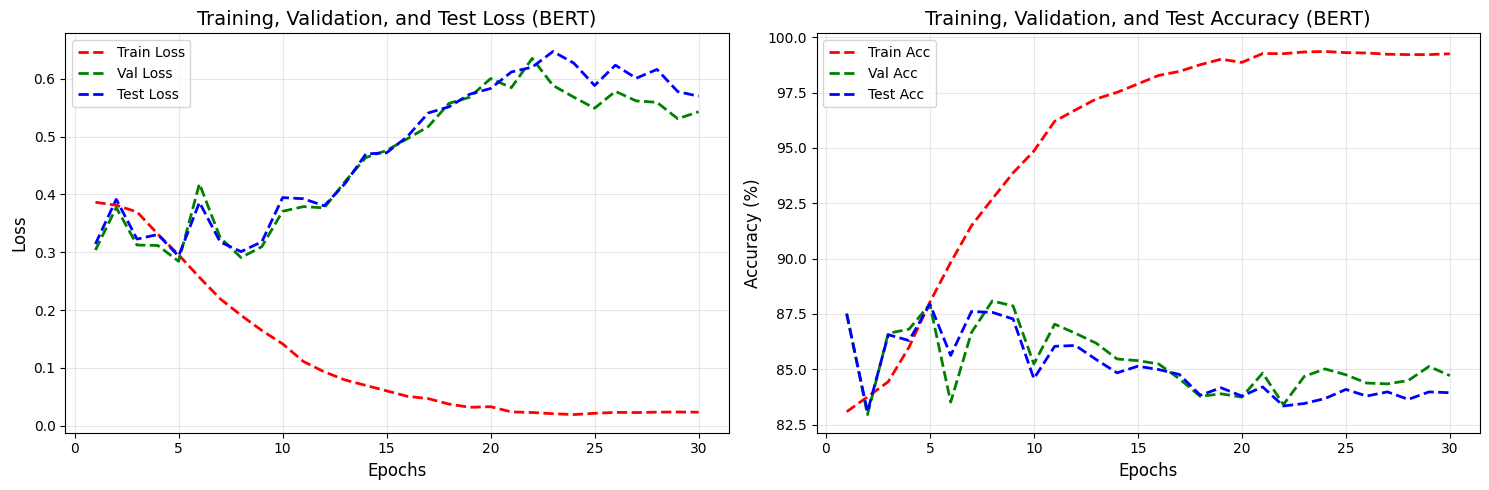

FINAL RESULTS (BERT Embeddings)
Best Validation Accuracy: 88.085%
Final Test Accuracy: 83.939%
Final Test Loss: 0.5697

Paper Results (from Table 2):
  Proposed method: 89.7%
  Our result: 83.939%
  Difference: -5.761%


In [ ]:
# Plot training curves
plt.figure(figsize=(15, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_loss_history, 'r--', label='Train Loss', linewidth=2)
plt.plot(range(1, epochs + 1), val_loss_history, 'g--', label='Val Loss', linewidth=2)
plt.plot(range(1, epochs + 1), test_loss_history, 'b--', label='Test Loss', linewidth=2)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training, Validation, and Test Loss (BERT)', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_acc_history, 'r--', label='Train Acc', linewidth=2)
plt.plot(range(1, epochs + 1), val_acc_history, 'g--', label='Val Acc', linewidth=2)
plt.plot(range(1, epochs + 1), test_acc_history, 'b--', label='Test Acc', linewidth=2)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Training, Validation, and Test Accuracy (BERT)', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves_bert.png', dpi=150, bbox_inches='tight')
plt.show()

# Print final results
print("=" * 80)
print("FINAL RESULTS (BERT Embeddings)")
print("=" * 80)
print(f"Best Validation Accuracy: {best_val_acc:.3f}%")
print(f"Final Test Accuracy: {test_acc_history[-1]:.3f}%")
print(f"Final Test Loss: {test_loss_history[-1]:.4f}")
print("=" * 80)

# Compare with paper results
print("\nPaper Results (from Table 2):")
print("  Proposed method: 89.7%")
print(f"  Our result: {test_acc_history[-1]:.3f}%")
print(f"  Difference: {test_acc_history[-1] - 89.7:.3f}%")

In [ ]:
#torch.save(model.state_dict(), '/content/drive/My Drive/computational_learning/final_project/base_bert_model_weights.pt')



state_dict = torch.load('/content/drive/My Drive/computational_learning/final_project/model_weights/base_bert_model_weights.pt', map_location=device)
loaded_model = model
loaded_model.load_state_dict(state_dict)
loaded_model.eval()


In [ ]:
# Load best model and evaluate - only after training
#checkpoint = torch.load('best_model_bert.pth')
#model.load_state_dict(checkpoint['state_dict'])
#print(f"Loaded best model from epoch {checkpoint['epoch']}")

# Final evaluation on test set
print("\nFinal evaluation on test set...")
final_test_acc, final_test_loss = validate(test_loader, model, criterion, device, tag='Final Test')
print(f"\nFinal Test Accuracy: {final_test_acc:.3f}%")
print(f"Final Test Loss: {final_test_loss:.4f}")


Final evaluation on test set...
Generating predictions for 2671 samples...

              FINAL TEST REPORT              
                   | Pred: NON  | Pred: SAR 
---------------------------------------------
Actual: NON        |    91.95% |     8.05%
---------------------------------------------
Actual: SAR        |    20.53% |    79.47%
Overall Test Accuracy: 86.26%

Final Test Accuracy: 86.260%
Final Test Loss: 0.3453
